In [ ]:
import numpy as np
import pandas as pd
from anndata import AnnData
import scanpy as sc, anndata as ad
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns

import scdrs

from tqdm import tqdm

import statsmodels.api as sm
import statsmodels.stats.multitest as multi

seed = 0
np.random.seed(seed)

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


# In[230]:


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
sc.settings.autosave = True
sc.logging.print_header()

version = 'pbmc_raw_adj-prop_magic'


import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

sc.settings.figdir = '../scanpy/{}/graph'.format(version)
sc.settings.cachedir = '../scanpy/{}/cache'.format(version)
# %config InlineBackend.figure_format = 'retina'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)

: 

In [ ]:
adata = sc.read('../scanpy/pbmc/pbmc.magic.h5ad')
adata

: 

In [ ]:
df_traits = pd.read_csv('../data/supp_table/trait_info.tsv', sep='\t')
df_traits.head()

: 

In [4]:
! seq 0 14 | xargs -P15 -I{} bash ../scripts/scDRS_batch_adj-prop_impute_pbmc.sh {}

+ mkdir -p ../scanpy/pbmc/scDRS_adj-prop_impute
+ mkdir -p ../scanpy/pbmc/scDRS_adj-prop_impute
+ mkdir -p ../scanpy/pbmc/scDRS_adj-prop_impute
+ mkdir -p ../scanpy/pbmc/scDRS_adj-prop_impute
+ scdrs compute-score --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad --h5ad-species human --gs-file ../data/gs_file/magma_10kb_top1000_zscore.75_traits.batch/batch0.gs --gs-species human --cov-file ../scanpy/pbmc/pbmc.cov.tsv --flag-filter-data False --flag-raw-count False --flag-return-ctrl-raw-score False --flag-return-ctrl-norm-score True --adj-prop cell_type --out-folder ../scanpy/pbmc/scDRS_adj-prop_impute
+ mkdir -p ../scanpy/pbmc/scDRS_adj-prop_impute
+ scdrs compute-score --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad --h5ad-species human --gs-file ../data/gs_file/magma_10kb_top1000_zscore.75_traits.batch/batch1.gs --gs-species human --cov-file ../scanpy/pbmc/pbmc.cov.tsv --flag-filter-data False --flag-raw-count False --flag-return-ctrl-raw-score False --flag-return-ctrl-norm-score True --adj-pro

In [ ]:
dict_score = {
    row['Trait Name']: pd.read_csv(f"../scanpy/pbmc/scDRS_adj-prop_impute/{row['Trait_Identifier']}.full_score.gz", 
    sep="\t", index_col=0)
    for pos,row in df_traits.iterrows()
}

# dict_score = {
#     row['Trait Name']: pd.read_csv(f"../scanpy/pbmc/scDRS_nofilter_magic/{row['Trait_Identifier']}.full_score.gz", 
#     sep="\t", index_col=0)
#     for pos,row in df_traits.iterrows()
# }

for trait in dict_score:
    adata.obs[trait] = dict_score[trait]["norm_score"]

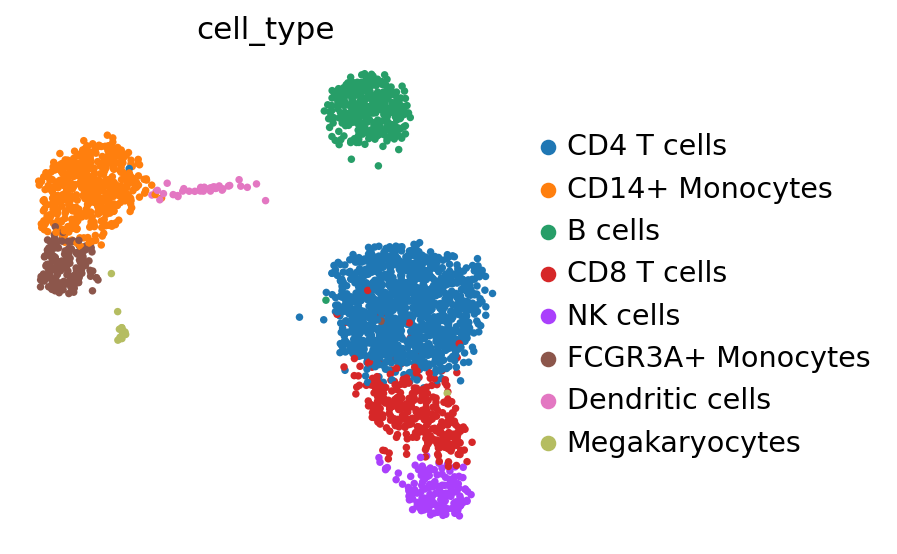

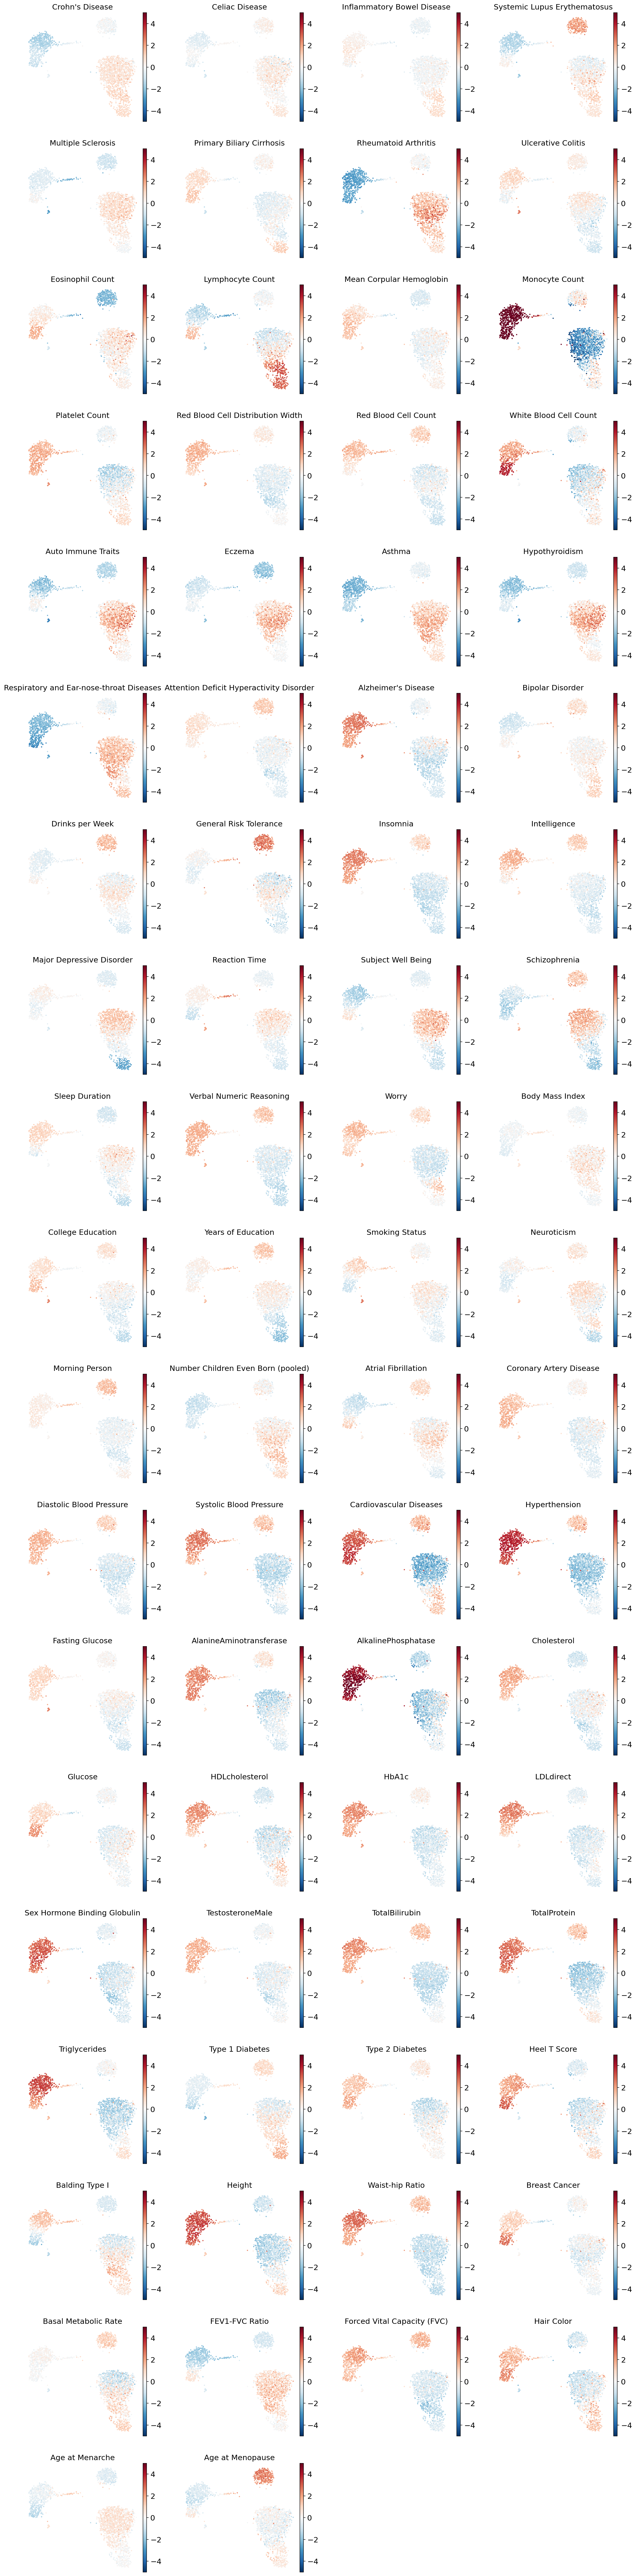

In [ ]:
sc.pl.umap(
    adata,
    color="cell_type",
    ncols=1,
    vmin=-5,
    vmax=5,
    save='celltype.png'
)

sc.pl.umap(
    adata,
    color=dict_score.keys(),
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
    s=20,
    save='disease_scores_adj-prop_impute.png'
)

%%capture

for trait in df_traits['Trait_Identifier']:
    print(```scdrs perform-downstream \
        --h5ad-file ../scanpy/220929_scDRS_various/pbmc.h5ad \
        --score-file ../scanpy/220929_scDRS_various/pbmc/scDRS/{trait}.full_score.gz \
        --out-folder ../scanpy/220929_scDRS_various/pbmc/scDRS \
        --group-analysis cell_type \
        --flag-filter-data True \
        --flag-raw-count True &```)

In [ ]:
for trait in df_traits['Trait_Identifier']:
    print('''scdrs perform-downstream \
        --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad \
        --score-file ../scanpy/pbmc/scDRS_adj-prop_impute/{}.full_score.gz \
        --out-folder ../scanpy/pbmc/scDRS_adj-prop_impute \
        --group-analysis cell_type \
        --flag-filter-data False \
        --flag-raw-count False &'''.format(trait))

scdrs perform-downstream         --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad         --score-file ../scanpy/pbmc/scDRS_adj-prop_impute/PASS_CD_deLange2017.full_score.gz         --out-folder ../scanpy/pbmc/scDRS_adj-prop_impute         --group-analysis cell_type         --flag-filter-data True         --flag-raw-count False &
scdrs perform-downstream         --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad         --score-file ../scanpy/pbmc/scDRS_adj-prop_impute/PASS_Celiac.full_score.gz         --out-folder ../scanpy/pbmc/scDRS_adj-prop_impute         --group-analysis cell_type         --flag-filter-data True         --flag-raw-count False &
scdrs perform-downstream         --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad         --score-file ../scanpy/pbmc/scDRS_adj-prop_impute/PASS_IBD_deLange2017.full_score.gz         --out-folder ../scanpy/pbmc/scDRS_adj-prop_impute         --group-analysis cell_type         --flag-filter-data True         --flag-raw-count False &
scdrs perform-downstream     

In [10]:
dict_df_stats = {
    row['Trait Name']: pd.read_csv(f"../scanpy/pbmc/scDRS_adj-prop_impute/{row['Trait_Identifier']}.scdrs_group.cell_type", 
    sep="\t", index_col=0)
    for pos,row in df_traits.iterrows()
}

# dict_df_stats = {
#     row['Trait Name']: pd.read_csv(f"../scanpy/pbmc/scDRS_nofilter_magic/{row['Trait_Identifier']}.scdrs_group.cell_type", 
#     sep="\t", index_col=0)
#     for pos,row in df_traits.iterrows()
# }

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/scdrs/util.py:557: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/scdrs/util.py:557: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


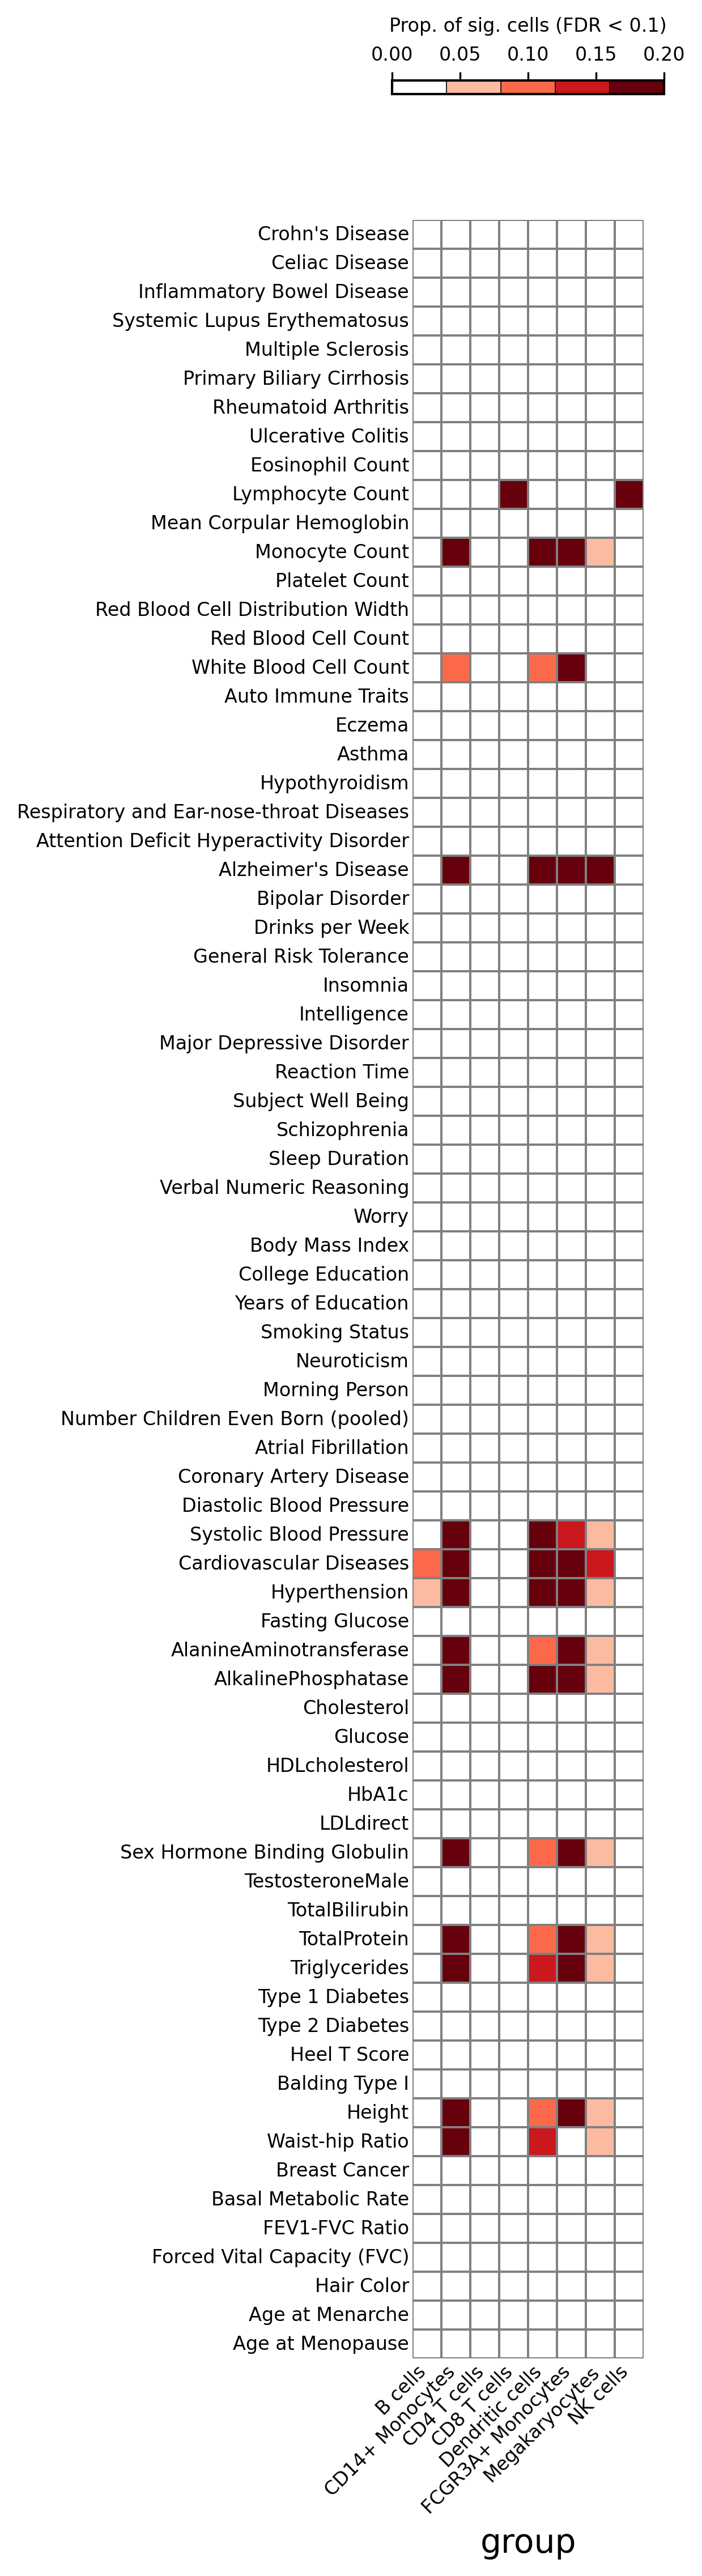

In [11]:
scdrs.util.plot_group_stats(
    {
        trait: df_stats
        for trait, df_stats in dict_df_stats.items()
    }
)
plt.savefig(str(sc.settings.figdir)+'/heatmap_raw.png', bbox_inches='tight')